<a href="https://colab.research.google.com/github/jenniferamhajduk/AIML_Playground/blob/main/Custom_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@InProceedings{cimpoi14describing,
	      Author    = {M. Cimpoi and S. Maji and I. Kokkinos and S. Mohamed and and A. Vedaldi},
	      Title     = {Describing Textures in the Wild},
	      Booktitle = {Proceedings of the {IEEE} Conf. on Computer Vision and Pattern Recognition ({CVPR})},
	      Year      = {2014}}

In [207]:
!pip install tqdm
!pip install torchmetrics
!pip install pytorch-ignite

In [208]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
import torch
from torch import nn
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from ignite.metrics import ConfusionMatrix
from ignite.engine import Engine, Events
from pathlib import Path
import pandas as pd
torch.__version__

'2.1.0+cu121'

In [209]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [210]:
!nvidia-smi

Mon Mar  4 05:48:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0              58W / 400W |   8895MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [211]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [212]:
train_data = datasets.DTD(
    root="data",
    split="train",
    partition=1,
    transform=transform,
    target_transform=None,
    download=True
)

test_data = datasets.DTD(
    root="data",
    split="test",
    partition=1,
    transform=transform,
    target_transform=None,
    download=True
)

val_data = datasets.DTD(
    root="data",
    split="val",
    partition=1,
    transform=transform,
    target_transform=None,
    download=True
)

In [213]:
len(train_data), len(test_data), len(val_data)

(1880, 1880, 1880)

In [214]:
image, target = train_data[0]

In [215]:
image, target

(tensor([[[1.0000, 1.0000, 0.9961,  ..., 0.5765, 0.9294, 0.9961],
          [1.0000, 1.0000, 0.9961,  ..., 0.5804, 0.9294, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.5804, 0.9294, 0.9961],
          ...,
          [1.0000, 1.0000, 0.9961,  ..., 0.5804, 0.9294, 0.9961],
          [1.0000, 1.0000, 0.9961,  ..., 0.5804, 0.9294, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.5804, 0.9294, 1.0000]],
 
         [[0.9765, 0.3294, 0.0118,  ..., 0.8745, 0.9529, 0.3216],
          [0.9765, 0.3294, 0.0118,  ..., 0.8745, 0.9529, 0.3255],
          [0.9765, 0.3294, 0.0118,  ..., 0.8745, 0.9529, 0.3255],
          ...,
          [0.9765, 0.3294, 0.0118,  ..., 0.8745, 0.9529, 0.3255],
          [0.9765, 0.3294, 0.0118,  ..., 0.8745, 0.9529, 0.3255],
          [0.9765, 0.3294, 0.0118,  ..., 0.8745, 0.9529, 0.3255]],
 
         [[0.9882, 0.6627, 0.5020,  ..., 0.3804, 0.8863, 0.6549],
          [0.9882, 0.6627, 0.5020,  ..., 0.3804, 0.8863, 0.6549],
          [0.9882, 0.6627, 0.5020,  ...,

In [216]:
image.shape

torch.Size([3, 64, 64])

In [217]:
classes = train_data.classes
classes

['banded',
 'blotchy',
 'braided',
 'bubbly',
 'bumpy',
 'chequered',
 'cobwebbed',
 'cracked',
 'crosshatched',
 'crystalline',
 'dotted',
 'fibrous',
 'flecked',
 'freckled',
 'frilly',
 'gauzy',
 'grid',
 'grooved',
 'honeycombed',
 'interlaced',
 'knitted',
 'lacelike',
 'lined',
 'marbled',
 'matted',
 'meshed',
 'paisley',
 'perforated',
 'pitted',
 'pleated',
 'polka-dotted',
 'porous',
 'potholed',
 'scaly',
 'smeared',
 'spiralled',
 'sprinkled',
 'stained',
 'stratified',
 'striped',
 'studded',
 'swirly',
 'veined',
 'waffled',
 'woven',
 'wrinkled',
 'zigzagged']

In [218]:
len(classes)

47

Text(0.5, 1.0, 'braided')

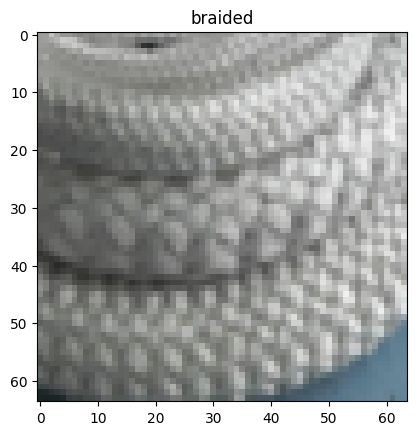

In [219]:
image, label = train_data[100]
image = image.squeeze(dim=1)
image = image.numpy()
image = image.transpose(1,2,0)
plt.imshow(image)
plt.title(classes[label])

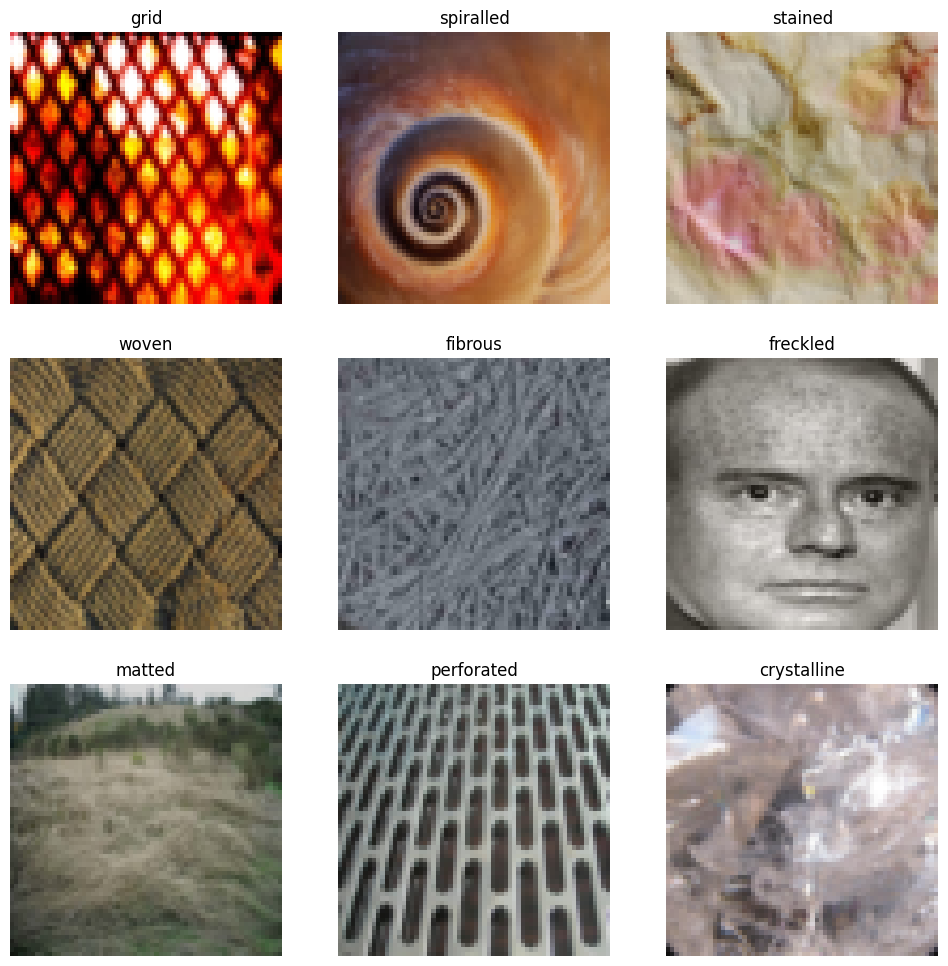

In [220]:
fig = plt.figure(figsize=(12,12))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
  rand_idx = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[rand_idx]
  image = image.numpy()
  image = image.transpose(1,2,0)
  fig.add_subplot(rows, cols, i)
  plt.imshow(image)
  plt.title(classes[label])
  plt.axis(False)

In [221]:
BATCH_SIZE=32

In [222]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

val_dataloader = DataLoader(
    dataset=val_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [223]:
class baseline_vision_classifier(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding="same"
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding="same"
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.dropout_1 = nn.Dropout2d(p=0.5)
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding="same"
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding="same"
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.dropout_2 = nn.Dropout2d(p=0.1)
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=hidden_units*256,
            out_features=output_shape
        )
    )

  def forward(self, x):
    #print("First Layer")
    x = self.conv_block_1(x)
    x = self.dropout_1(x)
    #print(x.shape)
    #print("Second Layer")
    x = self.conv_block_2(x)
    x = self.dropout_2(x)
   #print(x.shape)
    #print("Classifier Layer")
    out = self.classifier(x)
    return out


In [224]:
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of val_dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7ece33e85870>, <torch.utils.data.dataloader.DataLoader object at 0x7ece33e84d30>)
Length of train_dataloader: 59 batches of 32
Length of test_dataloader: 59 batches of 32
Length of val_dataloader: 59 batches of 32


In [225]:
def Accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [226]:
def print_training_time(
    start: float,
    end: float,
    device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time: .3f} seconds")

In [227]:
def train_loop(model: torch.nn.Module,
                epochs: int,
                train_loader: torch.utils.data.DataLoader,
                test_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.nn.Module,
                accuracy):
  print(f"Running: ", model.__class__.__name__)
  train_start_time = timer()
  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")
    train_loss, train_acc = 0, 0
    for batch, (X,y) in enumerate(train_loader):
      X, y = X.to(device), y.to(device)
      model.train()
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      train_loss += loss
      train_acc += Accuracy(y, y_pred.argmax(dim=1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_acc /= len(train_loader)
    train_loss /= len(train_loader)
    print(f"Train Accuracy: {train_acc: .2f}%, Train Loss: {train_loss: .4f}")


  test_loss, test_acc = 0,0
  with torch.inference_mode():
    for X_test, y_test in tqdm(test_loader):
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_pred = model(X_test)
      test_loss += loss_fn(test_pred, y_test)
      test_acc += Accuracy(y_test, test_pred.argmax(dim=1))

    test_loss /= len(test_loader)
    test_acc  /= len(test_loader)
    print(f"Test Accuracy: {test_acc: .2f}%, Test Loss: {test_loss: .4f}")

  training_end_time = timer()
  total_time = print_training_time(start=train_start_time, end=training_end_time, device=str(next(model.parameters()).device))

  return {"model_name": model.__class__.__name__,
          "model_loss": train_loss.item(),
          "model_acc": train_acc}

In [228]:
def eval_loop(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy):
  loss, acc = 0,0
  model.eval().to(device)
  with torch.inference_mode():
    for X, y in tqdm(loader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy(y, y_pred.argmax(dim=1))

    loss /= len(loader)
    acc /= len(loader)
    print(f"Eval Accuracy: {acc: .2f}%, Eval Loss: {loss: .4f}")


  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

In [229]:
EPOCHS=50
INPUT_SHAPE=3
HIDDEN_UNITS=1024
OUTPUT_SHAPE=47
LEARNING_RATE=0.01

In [230]:
baseline = baseline_vision_classifier(
    input_shape=INPUT_SHAPE,
    hidden_units=HIDDEN_UNITS,
    output_shape=OUTPUT_SHAPE
).to(device)

In [231]:
baseline

baseline_vision_classifier(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout_1): Dropout2d(p=0.5, inplace=False)
  (conv_block_2): Sequential(
    (0): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout_2): Dropout2d(p=0.1, inplace=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=262144, out_features=47, bias=True)
  )
)

In [232]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=baseline.parameters(), lr=LEARNING_RATE)

In [233]:
baseline_training = train_loop(model=baseline, epochs=EPOCHS, train_loader=train_dataloader, test_loader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy=Accuracy)
baseline_eval = eval_loop(model=baseline, loader=test_dataloader, loss_fn=loss_fn, accuracy=Accuracy)

Running:  baseline_vision_classifier


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Accuracy:  1.43%, Train Loss:  3.8574
Epoch: 1
Train Accuracy:  1.98%, Train Loss:  3.8493
Epoch: 2
Train Accuracy:  2.22%, Train Loss:  3.8439
Epoch: 3
Train Accuracy:  2.22%, Train Loss:  3.8373
Epoch: 4
Train Accuracy:  2.88%, Train Loss:  3.8273
Epoch: 5
Train Accuracy:  3.73%, Train Loss:  3.8141
Epoch: 6
Train Accuracy:  5.30%, Train Loss:  3.7899
Epoch: 7
Train Accuracy:  5.88%, Train Loss:  3.7590
Epoch: 8
Train Accuracy:  5.93%, Train Loss:  3.7405
Epoch: 9
Train Accuracy:  7.89%, Train Loss:  3.7092
Epoch: 10
Train Accuracy:  7.42%, Train Loss:  3.6786
Epoch: 11
Train Accuracy:  9.09%, Train Loss:  3.6458
Epoch: 12
Train Accuracy:  10.13%, Train Loss:  3.6115
Epoch: 13
Train Accuracy:  10.98%, Train Loss:  3.5882
Epoch: 14
Train Accuracy:  12.84%, Train Loss:  3.5191
Epoch: 15
Train Accuracy:  13.49%, Train Loss:  3.4780
Epoch: 16
Train Accuracy:  14.62%, Train Loss:  3.4334
Epoch: 17
Train Accuracy:  15.13%, Train Loss:  3.3839
Epoch: 18
Train Accuracy:  18.45

  0%|          | 0/59 [00:00<?, ?it/s]

Test Accuracy:  8.19%, Test Loss:  10.6647
Train time on cuda:0:  491.591 seconds


  0%|          | 0/59 [00:00<?, ?it/s]

Eval Accuracy:  8.28%, Eval Loss:  10.9054
